In [1]:
import numpy as np
import pandas as pd
import FlowCytometryTools as flow
import matplotlib.pyplot as plt

%matplotlib inline

### Data Import
Data handling: [http://eyurtsev.github.io/FlowCytometryTools/tutorial.html](http://eyurtsev.github.io/FlowCytometryTools/tutorial.html)

In [2]:
# Loading a file
datafile = "data/JF2017-01-06-B.0006.fcs"
sample = flow.FCMeasurement(ID='MG1655_sfGFP_mRFP1', datafile=datafile)

In [3]:
# Examining channels in the file
print sample.channel_names

(u'HDR-T', u'FSC-A', u'FSC-H', u'FSC-W', u'SSC-A', u'SSC-H', u'SSC-W', u'Y2-A', u'Y2-H', u'Y2-W', u'B1-A', u'B1-H', u'B1-W')


In [4]:
# YourSample.data returns a pandas dataframe with the raw data for each read
# I gatered 10k reads, 13 channels
print sample.data.shape

(10000, 13)


In [5]:
sample.data['B1-A'].min()

-67.313232

In [6]:
# And here's some data
print sample.data[['Y2-A', 'FSC-A']][:10]

          Y2-A         FSC-A
0  5306.313477   2721.044922
1  4736.391602  11533.376953
2    29.223442   3357.985352
3    17.695936  -6541.075195
4     4.721963   3233.231201
5  6466.929688   4459.637695
6  7095.660645  11265.457031
7  7982.730469   1869.270264
8  4455.803223   -294.199066
9  8064.943359  -2264.389648


In [7]:
# For retrieving the median
print sample.data['Y2-A'].median()

5442.88183594


### Plotting
Plotting gallery: [http://eyurtsev.github.io/FlowCytometryTools/gallery.html](http://eyurtsev.github.io/FlowCytometryTools/gallery.html)

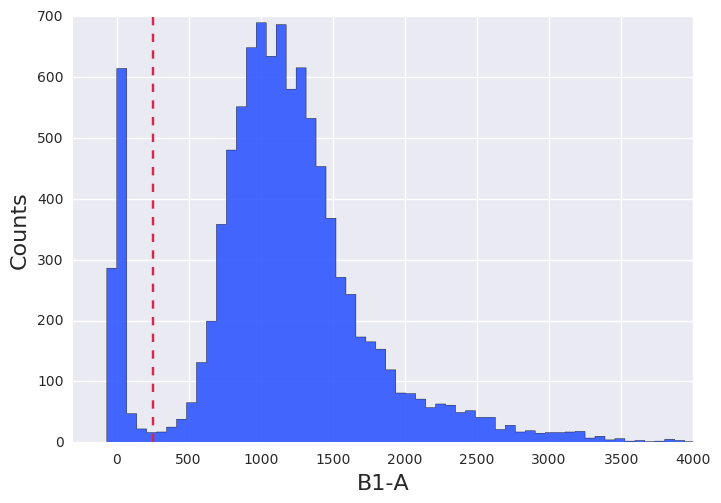

In [58]:
sample.plot('B1-A', color='#2F57FF', alpha=0.9, bins=100, grid=True)
plt.axvline(250, c="#D62750", linestyle="--")
plt.xlim(-300, 4000)
plt.savefig("fig1.png")

From the documentation: "Rather than having this transformation applied automatically and without your knowledge, this package provides a few of the common transformations (e.g., hlog, tlog), but ultimately leaves it up to you to decide how to manipulate your data. In the hlog transformation, the parameter b controls the location where the transformation shifts from linear to log. The optimal value for this parameter depends on the range of your data. For smaller ranges, try smaller values of b. So if your population doesn’t show up well, just adjust b."

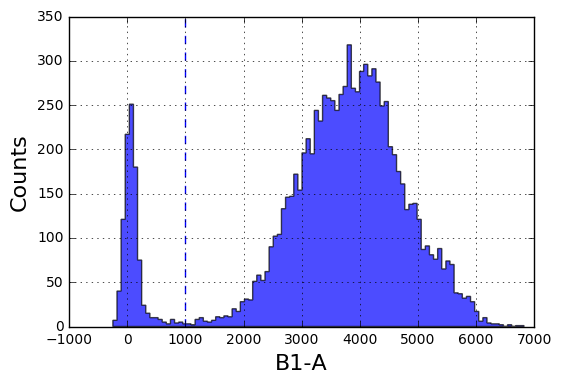

In [9]:
tsample = sample.transform('hlog',channels=['FSC-A', 'FSC-H', 'FSC-W', 'SSC-A', 'SSC-H', 'SSC-W', 'Y2-A', 'Y2-H', 'Y2-W', 'B1-A', 'B1-H', 'B1-W'], b=500.0)
tsample.plot('B1-A', color='blue', alpha=0.7, bins=100, grid=True)
plt.axvline(1000, c="blue", linestyle="--")
plt.savefig("fig2.png")

### Data labeling (classification)

In [10]:
## I'm going to use untransformed data for the supervised learning. Transformation just stretch the data but shouldn't 
## change the results.




def classifyReadsThreshold(sample, channel, threshold):
    # Classifying based on threshold
    Object_Type = np.array([])
    for i in sample.data[channel]:
        if i > threshold:
            Object_Type = np.append(Object_Type, 1)
        else:
            Object_Type = np.append(Object_Type, 9)
    data = sample.data
    data["Object_Type"] = Object_Type
    return data
    
channel = "B1-A"
# Setting an arbitrary threshold for fluorescent and non-fluorescent stuff.
threshold = 250

data = classifyReadsThreshold(sample, channel, threshold)
data.head()

,HDR-T,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W,Y2-A,Y2-H,Y2-W,B1-A,B1-H,B1-W,Object_Type
0,21.537766,2721.044922,5611.010742,63563.023438,5568.997070,4110.853027,177564.015625,5306.313477,3524.106689,197357.562500,1143.540771,617.507446,242727.718750,1.0
1,67.674721,11533.376953,10393.686523,145444.328125,3277.630615,2735.080322,157072.390625,4736.391602,3436.684814,180641.625000,997.152588,669.475952,195225.515625,1.0
2,91.303741,3357.985352,9336.948242,47139.371094,3384.410645,2674.267822,165877.734375,29.223442,98.610855,38843.339844,19.239727,99.402077,25369.585938,9.0
3,96.068352,-6541.075195,3363.389648,-254907.078125,5206.671387,4185.524902,163049.765625,17.695936,74.761513,31024.542969,0.721177,106.087509,891.020020,9.0
4,133.085709,3233.231201,7134.643555,59398.351562,4759.702637,3840.285889,162452.421875,4.721963,80.450211,7693.170410,28.822926,61.786156,61144.417969,9.0


In [11]:
noncells = data[data["Object_Type"] == 9] 
noncells["B1-A"].max()

244.94321

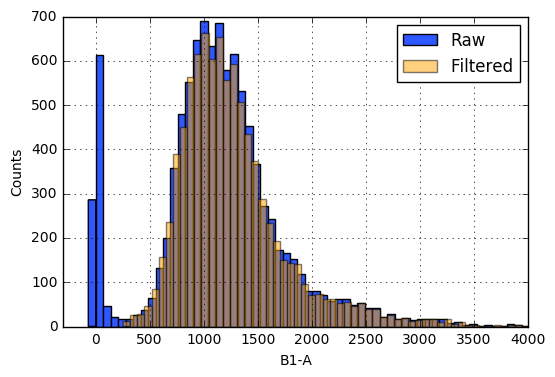

In [12]:
# here's what the manual cleaning did
data_preprocessed = data[data["Object_Type"] == 1] 
plt.grid()
plt.hist(data["B1-A"], color="#2F57FF", bins = 100, label="Raw");
plt.hist(data_preprocessed["B1-A"], bins=100, alpha= 0.5, color="orange", label = "Filtered")
plt.xlim(-300, 4000)
plt.ylabel("Counts")
plt.xlabel("B1-A")
plt.legend()
plt.savefig("fig3.png")

In [13]:
import seaborn as sns

## Plotting relationship between each parameter that we'll use in machine learning
channels_plot = list(tsample.channel_names[1:7]) + ["Object_Type"]
data_plots = data[channels_plot]

#plt.rcParams['axes.labelsize'] = 18
#plt.rcParams['xtick.labelsize'] = 0
#plt.rcParams['ytick.labelsize'] = 0


#sns.pairplot(data_plots[9000:], hue="Object_Type", size=3.5, x_vars=data_plots.columns[0:len(data_plots.columns)-1], y_vars=data_plots.columns[0:len(data_plots.columns)-1])
#plt.savefig("fig4b.png")
#plt.rcdefaults()


### Generating data for supervised learning

In [14]:
# Using supervised learning with all the scatter measurements, non transformed data
X = sample.data[list(sample.channel_names[1:7])]

In [15]:
X[:10]

,FSC-A,FSC-H,FSC-W,SSC-A,SSC-H,SSC-W
0,2721.044922,5611.010742,63563.023438,5568.997070,4110.853027,177564.015625
1,11533.376953,10393.686523,145444.328125,3277.630615,2735.080322,157072.390625
2,3357.985352,9336.948242,47139.371094,3384.410645,2674.267822,165877.734375
3,-6541.075195,3363.389648,-254907.078125,5206.671387,4185.524902,163049.765625
4,3233.231201,7134.643555,59398.351562,4759.702637,3840.285889,162452.421875
5,4459.637695,6110.441895,95661.437500,6132.524902,5203.037598,154487.125000
6,11265.457031,10336.461914,142852.171875,3344.814941,2670.672607,164157.734375
7,1869.270264,10825.398438,22632.792969,11768.268555,9451.333984,163203.468750
8,-294.199066,4043.216064,-9537.274414,4447.352539,3454.984375,168719.546875
9,-2264.389648,6595.055176,-45003.125000,12359.852539,9763.746094,165923.062500


In [16]:
y = data["Object_Type"]
y[:10]

0    1.0
1    1.0
2    9.0
3    9.0
4    9.0
5    1.0
6    1.0
7    1.0
8    1.0
9    1.0
Name: Object_Type, dtype: float64

### Prototyping supervised learning code

In [17]:
from sklearn.model_selection import train_test_split

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.mixture import GaussianMixture
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis


In [18]:
def generateModel(model, X_train, y_train):
    model_trained = model.fit(X_train, y_train)
    return model_trained

def validateModel(model_trained, X_test, y_test):    
    prediction = model_trained.predict(X_test)
    accuracy = np.mean(prediction == y_test)
    return accuracy 

def evaluateCleaning(model_trained, X_test, y_test, plot):
    # Considering only non-cells
    y_test_noncells = y_test[y_test == 9]
    X_test_noncells = X_test.ix[y_test_noncells.index]
    # Predicting
    ## need to edit here so that it does PCA before predicting
    prediction = model_trained.predict(X_test_noncells[list(X.columns[0:len(X.columns)-1])])

    accuracy = np.mean(prediction == y_test_noncells)
    # Computing % cleaned
    X_test_noncells["Prediction"] = prediction
    X_test_noncells_predicted = X_test_noncells[X_test_noncells["Prediction"] == 9]
    percentCleaned = 100 * (X_test_noncells_predicted.shape[0]/float(X_test_noncells.shape[0]))
    ## non cells predicted / total non cells : how many we can clean using a threshold
    
    # plotting
    if plot == True:
        plt.hist(X_test_noncells["B1-A"], bins= 50, label = "Non-Cells in Sample");
        plt.hist(X_test_noncells_filtered["B1-A"], bins= 50, alpha= 0.5, color="orange", label = "Predicted Non-Cells");
        plt.ylabel("Counts")
        plt.xlabel("B1-A")
        plt.legend()
    
    return percentCleaned


In [19]:
list(sample.channel_names[1:len(X.columns)])

[u'FSC-A', u'FSC-H', u'FSC-W', u'SSC-A', u'SSC-H']

In [20]:
from sklearn.decomposition import PCA

def modelPerformance(model, X, test_fract, reps, pca):
    accuracy = np.array([])
    percentCleaned = np.array([])

    for i in range(reps):
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_fract)
        
        if pca == True:
            X_train_PCA = PCA()
            ## Using only scatter even if X has other stuff in it
            X_train_red = X_train_PCA.fit_transform(X_train[list(X.columns[0:len(X.columns)-1])])
            X_test_PCA = PCA()
            X_test_red = X_test_PCA.fit_transform(X_test[list(X.columns[0:len(X.columns)-1])])
            
            model_trained = generateModel(model, X_train_red, y_train)
            accuracy = np.append(accuracy, validateModel(model_trained, X_test_red, y_test))
            ## need to edit evaluateCleaning so that it's agnostic on data going in: pca or no pca case?
            return np.mean(accuracy)
        
        else:
            ## train and predict, using all measurments but last (fluorescence that we use for classifying)
            model_trained = generateModel(model, X_train[list(X.columns[0:len(X.columns)-1])], y_train)
            accuracy = np.append(accuracy, validateModel(model_trained, X_test[list(X.columns[0:len(X.columns)-1])], y_test))
            percentCleaned = np.append(percentCleaned, evaluateCleaning(model_trained, X_test, y_test, plot=False))
    
    if pca == True:
        return np.mean(accuracy)
    else:
        return np.mean(accuracy), np.mean(percentCleaned)

X = sample.data[list(sample.channel_names[1:7]) + ["B1-A"]]
y = data["Object_Type"]
reps = 10
test_fract = 0.2
model = KNeighborsClassifier(n_neighbors=44)

modelPerformance(model, X, test_fract, reps, pca=False)

(0.91639999999999999, 19.589412802472008)

In [21]:
import types 

def compareModelPerformance(models, X, test_fract, reps, plot, pca):
    verbose = False
    
    accuracy_log = np.array([])
    percentCleaned_log = np.array([])
    
    if type(models) <> list: models = [models]
    
    for model in models:
        accuracy, percentCleaned = modelPerformance(model, X, test_fract, reps, pca)
        accuracy_log = np.append(accuracy_log, accuracy)
        percentCleaned_log = np.append(percentCleaned_log, percentCleaned)
        if verbose == True:
            print "Completed step using model: " + str(model)
        
    if plot == True:
        print "Still coding plotting fuction"
        # plotting function
    return accuracy_log, percentCleaned_log



In [22]:
X = sample.data[list(sample.channel_names[1:7]) + ["B1-A"]]
reps = 100
test_fract = 0.2
models = [KNeighborsClassifier(n_neighbors=10), 
          KNeighborsClassifier(n_neighbors=44), 
          KNeighborsClassifier(n_neighbors=70),
          LinearDiscriminantAnalysis(solver="svd"),
          LinearDiscriminantAnalysis(solver="lsqr"),
          DecisionTreeClassifier(max_depth=5),
          DecisionTreeClassifier(max_depth=2),
          DecisionTreeClassifier(),
          GaussianMixture(covariance_type="spherical"),
          GaussianMixture(covariance_type="tied"),
          GaussianMixture(covariance_type="diag"),
          GaussianMixture(covariance_type="full"),
          RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
          RandomForestClassifier(),
          MLPClassifier(alpha=1),
          MLPClassifier(),
          AdaBoostClassifier(),
          GaussianNB(),
          QuadraticDiscriminantAnalysis() 
         ]



accuracy_log_0, percentCleaned_log_0 = compareModelPerformance(models, X, test_fract, reps, plot=False, pca=False)
# LDA parameters? solver = 'svd', 'lsqr'
# SVC parameters? kernel = ‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’
# Gaussian mixtures: covariance-types cv_types = ['spherical', 'tied', 'diag', 'full'], n_components: try 1 to 7

percentCleaned_log_0, accuracy_log_0

(array([ 19.8243192 ,  19.98703727,  18.90668478,  22.14974269,
         22.33843694,  24.9124402 ,  22.69108404,  35.19268798,
          0.        ,   0.        ,   0.        ,   0.        ,
         24.06405117,  26.44821689,  25.9138061 ,  27.60754727,
         24.06999375,  27.18759906,  27.73592968]),
 array([ 0.91708 ,  0.916425,  0.91493 ,  0.9177  ,  0.917675,  0.9202  ,
         0.918895,  0.863705,  0.      ,  0.      ,  0.      ,  0.      ,
         0.9209  ,  0.917645,  0.868985,  0.863525,  0.918975,  0.912475,
         0.91296 ]))

In [23]:
modelNames = ["10-NN", "44-NN", "70-NN", "LDA-svd", "LDA-lsqr", "DT-d5", "DT-d2", "DT-dmax","GM-sph", "GM-tied", "GM-diag", "GM-full", "RF-5-10-1", "RF", "NN-1", "NN","AB","NB", "QDA"]

0.8654434250764527

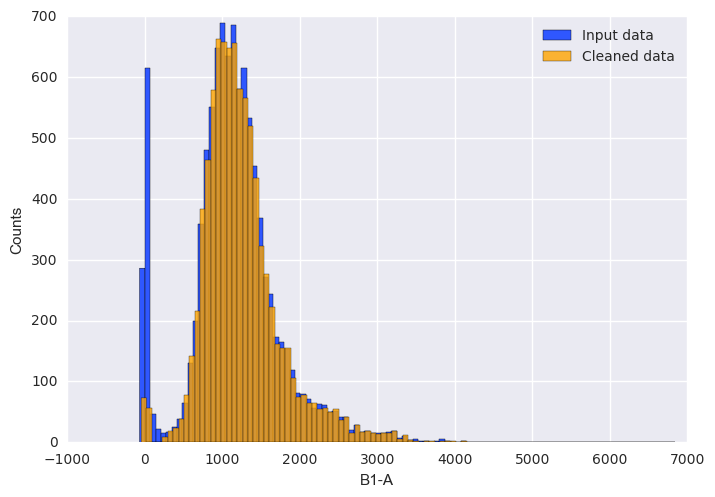

In [24]:
# Let's see how the best model performs in cleaning the sample

def cleanSampleIndex(model_trained, X, plot):
    # need to create X with proper columns so that the last is B1
    
    prediction = model_trained.predict(X[list(X.columns[0:len(X.columns)-1])])
    X["prediction"] = prediction
    X_cleaned = X[X["prediction"] == 1]
    
    if plot == True:
        plt.hist(X["B1-A"], color="#2F57FF", bins=100, label = "Input data")
        plt.hist(X_cleaned["B1-A"], bins=100, color="orange", alpha= 0.8, label="Cleaned data")
        plt.legend()
        plt.ylabel("Counts")
        plt.xlabel("B1-A")
    
    return X_cleaned

X = sample.data[list(sample.channel_names[1:7]) + ["B1-A"]]
model = DecisionTreeClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model_trained = generateModel(model, X_train[list(sample.channel_names[1:len(X.columns)])], y_train)
X_cleaned_i = cleanSampleIndex(model_trained, X, plot=True);
plt.savefig("fig5.png")

X_cleaned = data.ix[X_cleaned_i.index]
X_cleaned_noncells = X_cleaned[X_cleaned["Object_Type"] == 9]
1 - (X_cleaned_noncells.shape[0]/ float(data[data["Object_Type"]== 9].shape[0]))
## non cells cleaned = 1 - (remaining non cells after prediction / total non cells) 

In [45]:
# Positive control: including a second fluorescent reporter in model training. Does this improve percentCleaned?
X = sample.data[list(sample.channel_names[1:7]) + ["Y2-A"] + ["B1-A"]]
accuracy_log_1, percentCleaned_log_1 = compareModelPerformance(models, X, test_fract, reps, plot=False, pca=False)

# Yes, we get up to 96% cleaning with decition tree classifiers. This is telling us that the alogorithm is working well,
# but the scattering measurements don't have enough information to prperly classify non-cells reads (or that they're
# very similar to cell reads)
percentCleaned_log_1, accuracy_log_1

(array([ 23.386484  ,  19.37818601,  18.57252312,  46.67536709,
         46.49038249,  95.34829041,  95.90034262,  92.49264122,
          0.        ,   0.        ,   0.        ,   0.        ,
         74.17808111,  94.33018908,  83.49127579,  82.73452179,
         96.64190769,  29.39969886,  30.73512915]),
 array([ 0.92114 ,  0.91602 ,  0.913985,  0.940885,  0.940245,  0.988855,
         0.990015,  0.98559 ,  0.      ,  0.      ,  0.      ,  0.      ,
         0.96871 ,  0.98882 ,  0.96499 ,  0.968485,  0.98996 ,  0.925885,
         0.92557 ]))

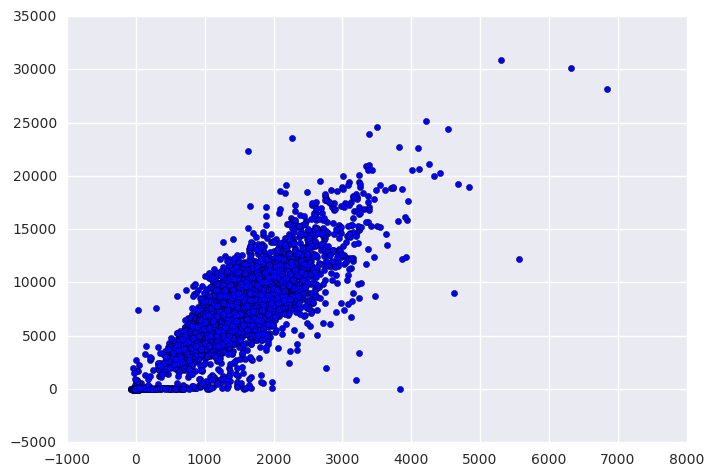

In [46]:
plt.scatter(X["B1-A"], X["Y2-A"])

In [44]:
percentCleaned_log_1 - percentCleaned_log_0, 100*(accuracy_log_1 - accuracy_log_0)

(array([  3.55741379,  -0.71656343,  -0.2475673 ,  24.58229982,
         24.38001306,  70.62888745,  73.47742573,  57.30730678,
          0.        ,   0.        ,   0.        ,   0.        ,
         49.31494357,  68.37350262,  56.19414781,  54.80059952,
         72.37786277,   2.53805755,   2.96111177]),
 array([  0.4095,  -0.0395,  -0.0415,   2.2965,   2.307 ,   6.855 ,
          7.203 ,  12.166 ,   0.    ,   0.    ,   0.    ,   0.    ,
          4.731 ,   7.1935,   9.549 ,  10.2655,   7.0875,   1.3015,   1.3755]))

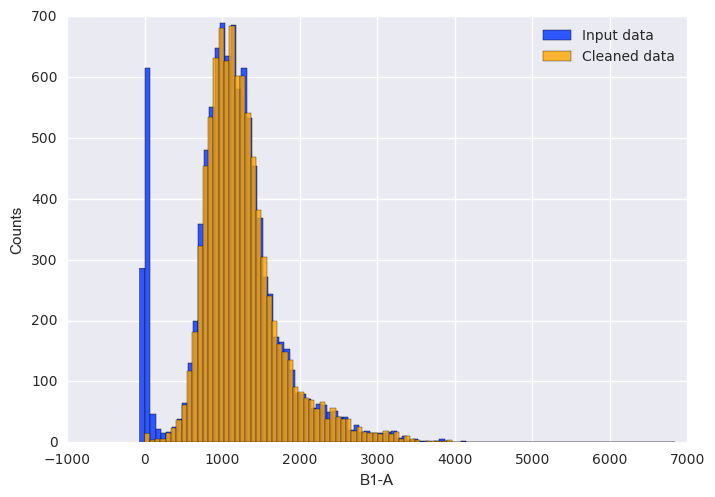

In [26]:
# Here is the performance of the model using Y2-A
X = sample.data[list(sample.channel_names[1:7]) + ["Y2-A"] + ["B1-A"]]
model = DecisionTreeClassifier()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model_trained = generateModel(model, X_train[list(sample.channel_names[1:len(X.columns)])], y_train)
cleanSampleIndex(model_trained, X, plot=True);
plt.savefig("fig6.png")

In [27]:
# Is there a relationship between each single parameter and objectype? 

#sns.pairplot(data_plots[9000:],aspect=3, hue="Object_Type", x_vars="Object_Type", y_vars=data_plots.columns[0:len(data_plots.columns)-1]);


In [28]:
# generating datasets for single parameters        
X = sample.data[[sample.channel_names[1]] + ["B1-A"]]
accuracy_log, percentCleaned_log = compareModelPerformance(models, X, test_fract, reps, plot=False, pca=False)

accuracy_table = accuracy_log*100
percentCleaned_table = percentCleaned_log

for i in list(sample.channel_names[2:10]):
    X = sample.data[[i] + ["B1-A"]]    
    accuracy_log, percentCleaned_log = compareModelPerformance(models, X, test_fract, reps, plot=False, pca=False)
        
    accuracy_table = np.vstack([accuracy_table, accuracy_log*100])
    percentCleaned_table = np.vstack([percentCleaned_table, percentCleaned_log])

In [29]:
accuracy_table = pd.DataFrame(accuracy_table, columns=modelNames, index=list(sample.channel_names[1:10]))
accuracy_table

,10-NN,44-NN,70-NN,LDA-svd,LDA-lsqr,DT-d5,DT-d2,DT-dmax,GM-sph,GM-tied,GM-diag,GM-full,RF-5-10-1,RF,NN-1,NN,AB,NB,QDA
FSC-A,91.3340,91.3755,91.3785,91.4545,91.3970,91.3990,91.5205,85.2200,0.0,0.0,0.0,0.0,91.5505,86.5770,69.0130,69.1220,91.5165,91.0100,90.9280
FSC-H,91.5065,91.4855,91.6525,91.3620,91.3120,91.5605,91.5125,85.6365,0.0,0.0,0.0,0.0,91.6935,86.7835,57.8700,54.4550,91.5940,91.6335,91.6675
FSC-W,89.9395,90.2555,90.0975,90.2190,90.1335,90.1790,90.2500,83.7805,0.0,0.0,0.0,0.0,90.2330,85.1625,84.7085,82.2010,90.1600,89.0665,89.1115
SSC-A,91.5585,91.7540,91.6325,91.3120,91.1935,91.4155,91.5605,85.7505,0.0,0.0,0.0,0.0,91.5050,86.9095,65.0155,61.2980,91.6045,91.4505,91.4215
SSC-H,90.9985,91.2845,91.1275,90.8585,90.8100,91.1500,91.2030,85.7305,0.0,0.0,0.0,0.0,91.2345,86.6380,67.8025,74.5710,91.2850,91.0910,91.0045
SSC-W,89.9380,90.0495,90.1500,88.4630,88.3265,90.0425,90.2045,84.0315,0.0,0.0,0.0,0.0,90.0405,85.4180,81.4160,80.4510,90.1540,87.5915,87.4855
Y2-A,99.0360,99.0260,98.9870,98.8500,98.9010,98.9190,99.0710,98.3665,0.0,0.0,0.0,0.0,99.0500,98.5450,98.5420,98.6375,99.0125,98.8520,98.8275
Y2-H,98.9995,99.0100,98.8935,98.7815,98.7920,98.9420,99.0195,98.4025,0.0,0.0,0.0,0.0,98.9670,98.6070,98.7780,98.6460,99.0495,98.8230,98.8065
Y2-W,98.9285,99.0425,99.0125,98.5485,98.6030,98.8575,98.9590,98.2375,0.0,0.0,0.0,0.0,98.9260,98.3930,91.1355,92.7985,98.9310,98.9515,98.9255


In [30]:
percentCleaned_table = pd.DataFrame(percentCleaned_table, columns=modelNames, index=list(sample.channel_names[1:10]))
percentCleaned_table

,10-NN,44-NN,70-NN,LDA-svd,LDA-lsqr,DT-d5,DT-d2,DT-dmax,GM-sph,GM-tied,GM-diag,GM-full,RF-5-10-1,RF,NN-1,NN,AB,NB,QDA
FSC-A,18.666751,19.274860,19.165820,21.151954,20.613498,21.438083,22.354031,26.367833,0.0,0.0,0.0,0.0,21.134019,25.314012,26.311867,26.056970,23.026314,23.209918,23.581152
FSC-H,19.317884,21.150250,21.561948,16.754581,17.251100,21.493132,22.475773,28.292562,0.0,0.0,0.0,0.0,22.318216,26.795031,40.670133,45.020381,23.844028,19.691433,19.506898
FSC-W,0.905176,0.000000,0.000000,0.000000,0.000000,0.168417,0.000000,5.949302,0.0,0.0,0.0,0.0,0.067064,4.676272,6.873663,9.954888,0.141207,2.810730,2.678358
SSC-A,20.146718,21.227903,20.654644,16.069138,16.264237,20.419429,20.569781,28.916533,0.0,0.0,0.0,0.0,20.806891,26.523520,31.189014,35.774844,21.982628,18.254375,18.259410
SSC-H,15.664610,17.307494,16.201159,10.906164,10.878514,18.215722,18.276264,29.316805,0.0,0.0,0.0,0.0,17.878925,26.794314,27.511380,19.271167,18.729169,13.664096,13.489568
SSC-W,3.458062,1.453674,0.227723,25.355289,25.015604,0.142991,0.000000,6.641682,0.0,0.0,0.0,0.0,0.000000,5.187771,11.000000,12.000000,0.005464,27.077736,26.861481
Y2-A,95.909702,97.094014,97.400138,97.844705,98.022123,95.550942,95.891039,91.438924,0.0,0.0,0.0,0.0,96.373741,92.705492,93.322952,94.922878,95.864250,98.026574,98.030175
Y2-H,96.758068,97.514071,97.810436,98.609844,98.389212,96.552400,96.902468,92.896537,0.0,0.0,0.0,0.0,96.918265,94.259907,97.829582,95.909539,97.143043,98.464562,98.334353
Y2-W,96.127744,96.620217,96.470057,90.578293,90.736839,95.813342,96.606944,91.193443,0.0,0.0,0.0,0.0,96.166219,91.532495,29.056870,27.345626,96.421089,94.826131,95.050181


In [31]:
# Adding previous all scatter and all scatter + Y2-A results to the table
accuracy_table_01= np.vstack([accuracy_log_0, accuracy_log_1])
percentCleaned_table_01= np.vstack([percentCleaned_log_0, percentCleaned_log_1])

accuracy_table_01 = pd.DataFrame(accuracy_table_01, columns=modelNames, index=["All Scatter", "All Scatter + Y-2A"])
percentCleaned_table_01 = pd.DataFrame(percentCleaned_table_01, columns=modelNames, index=["All Scatter", "All Scatter + Y-2A"])

accuracy_table_all = pd.concat([accuracy_table_01*100, accuracy_table])
percentCleaned_table_all = pd.concat([percentCleaned_table_01, percentCleaned_table])

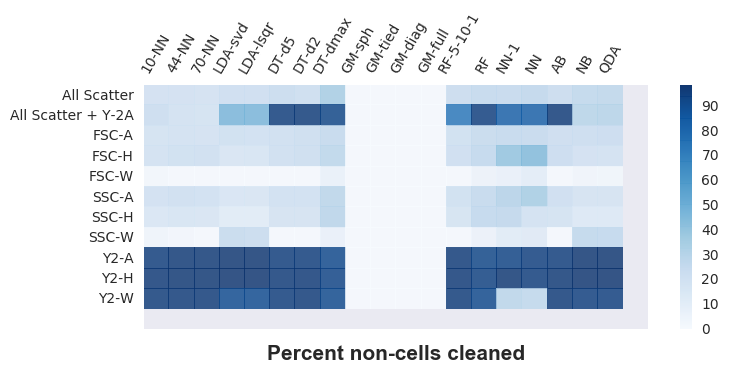

In [80]:
# Plot it out
# code adapted from here http://stackoverflow.com/questions/14391959/heatmap-in-matplotlib-with-pcolor

fig, ax = plt.subplots()
heatmap = ax.pcolor(percentCleaned_table_all, cmap=plt.cm.Blues, alpha=0.8)

# Format
fig = plt.gcf()
fig.set_size_inches(8, 4)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(percentCleaned_table_all.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(percentCleaned_table_all.shape[1]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(modelNames, minor=False)
ax.set_yticklabels(percentCleaned_table_all.index, minor=False)
plt.xticks(rotation=60)
ax.grid(False)

# need to move title
# need to add legend
ax.set_title("Percent non-cells cleaned", y=-0.15, fontweight="bold", fontsize=15)
plt.colorbar(heatmap)
plt.tight_layout()
plt.savefig("heatmap-percentCleaned.png")

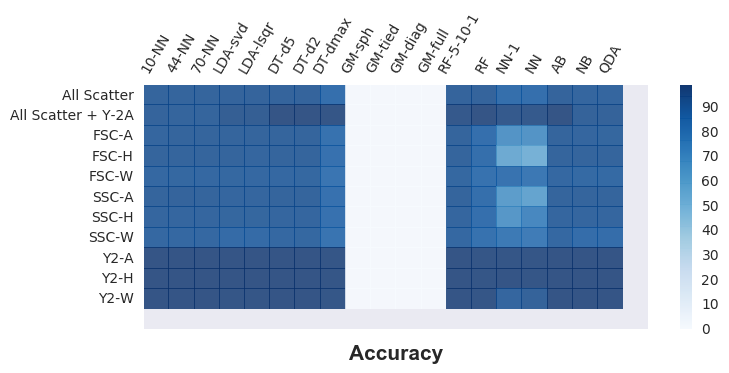

In [78]:
# Plot it out
# code adapted from here http://stackoverflow.com/questions/14391959/heatmap-in-matplotlib-with-pcolor

fig, ax = plt.subplots()
heatmap = ax.pcolor(accuracy_table_all, cmap=plt.cm.Blues, alpha=0.8)

# Format
fig = plt.gcf()
fig.set_size_inches(8, 4)

# put the major ticks at the middle of each cell
ax.set_yticks(np.arange(accuracy_table_all.shape[0]) + 0.5, minor=False)
ax.set_xticks(np.arange(accuracy_table_all.shape[1]) + 0.5, minor=False)

# want a more natural, table-like display
ax.invert_yaxis()
ax.xaxis.tick_top()

ax.set_xticklabels(modelNames, minor=False)
ax.set_yticklabels(accuracy_table_all.index, minor=False)
plt.xticks(rotation=60)
ax.grid(False)

ax.set_title("Accuracy", y=-0.15, fontweight="bold", fontsize=15)
plt.colorbar(heatmap)
plt.tight_layout()
plt.savefig("heatmap-accuracy.png")

In [34]:
# conclusion: most of the performance is explained by the Y2 channel.
# None of the single parameters, other than Y2-A are good enough for triggering.
# Using scatter + Y2-A actually performes worse that Y2-A alone, suggesting the other measurements 
# might be confounding the data


# SVM crashed my computer

### Applying the model to a new sample

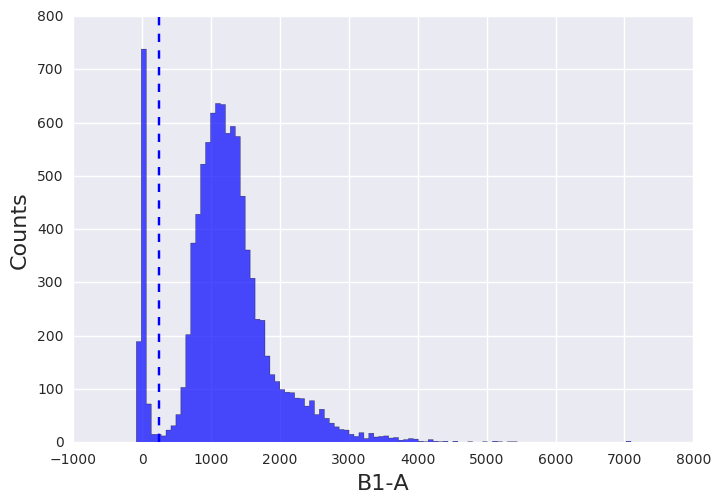

In [60]:
# Opening a new file and checking that the threshold still works
datafile2 = "data/JF2017-01-06-B.0007.fcs"
sample2 = flow.FCMeasurement(ID='MG1655_sfGFP_mRFP1', datafile=datafile2)
sample2.plot('B1-A', color='blue', alpha=0.7, bins=100, grid=True)
plt.axvline(250, c="blue", linestyle="--")

26.99805068226121

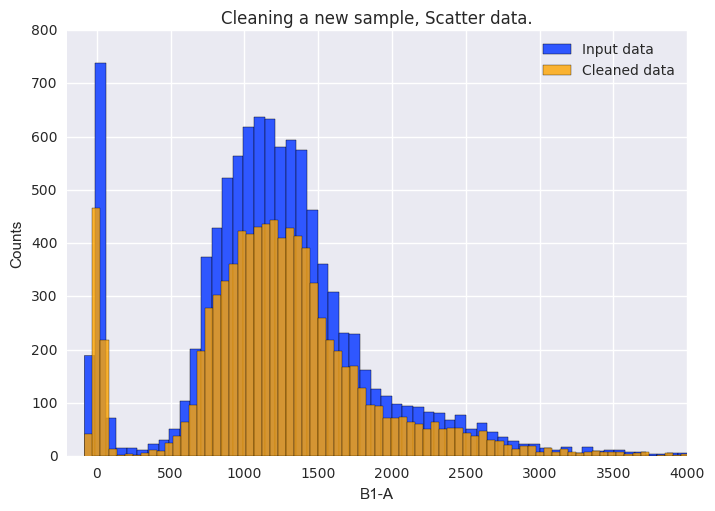

In [75]:
# training on the sample we used so far
X = sample.data[list(sample.channel_names[1:7]) + ["B1-A"]]
model = DecisionTreeClassifier()


model_trained = generateModel(model, X[list(sample.channel_names[1:len(X.columns)])], y)


# generating dataset for new sample
channel = "B1-A"
# Setting an arbitrary threshold for fluorescent and non-fluorescent stuff.
threshold = 250
data2 = classifyReadsThreshold(sample2, channel, threshold)
X2 = sample2.data[list(sample2.channel_names[1:7]) + ["B1-A"]]
y2 = data2["Object_Type"]

# cleaning new sample
X2_cleaned_i = cleanSampleIndex(model_trained, X2, plot=True);
plt.title("Cleaning a new sample, Scatter data.")
plt.xlim(-200, 4000)
plt.savefig("Fig10.png")
#print X2_cleaned_i.shape[0]


#X2_cleaned = data.ix[X2_cleaned_i.index]
#X2_cleaned_noncells = X2_cleaned[X2_cleaned["Object_Type"] == 9]
#1 - (X2_cleaned_noncells.shape[0]/ float(data2[data2["Object_Type"]== 9].shape[0]))

#validateModel(model_trained, X2, y2)
evaluateCleaning(model_trained, X2, y2, plot=False)


95.6140350877193

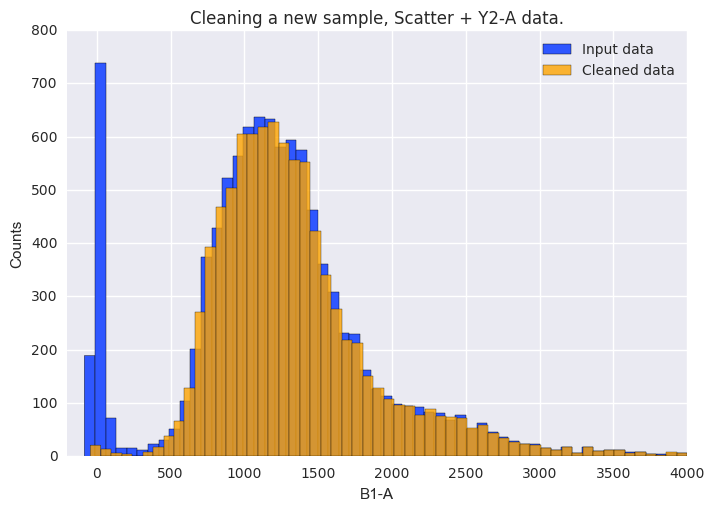

In [74]:
X = sample.data[list(sample.channel_names[1:7]) + ["Y2-A"] + ["B1-A"]]
model = DecisionTreeClassifier()

model_trained = generateModel(model, X[list(sample.channel_names[1:len(X.columns)])], y)


X2 = sample2.data[list(sample2.channel_names[1:7]) + ["Y2-A"] + ["B1-A"]]


# cleaning new sample
X2_cleaned_i = cleanSampleIndex(model_trained, X2, plot=True);
plt.xlim(-200, 4000)
plt.title("Cleaning a new sample, Scatter + Y2-A data.")
plt.savefig("Fig11.png")


X2_cleaned = data.ix[X2_cleaned_i.index]
X2_cleaned_noncells = X2_cleaned[X2_cleaned["Object_Type"] == 9]
1 - (X2_cleaned_noncells.shape[0]/ float(data2[data2["Object_Type"]== 9].shape[0]))

  
#validateModel(model_trained, X2, y2)
evaluateCleaning(model_trained, X2, y2, plot=False)

### Plotting and comparison between classifiers
[Compare classifiers](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)
[Plot decision boundaries](http://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html#sphx-glr-auto-examples-classification-plot-classifier-comparison-py)